In [2]:
import pandas as pd
import numpy as np
import networkx as nx 


from os.path import join
import os

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['PROJECT_PATH']
covalent_key = os.environ['COVALENTHQ_API_KEY']

# Statistically Validated Networks in Bipartite Complex Systems

For the analysis we sub-divide the our data into two sub-set.

- N_A = Set of 17 Token addresses 
    > |Note: Tokenmigration or wrapped version (e.g. wNXM) have been replace with the address of the corresponding address. 
- N_B = Remainder of 78700610 (78700627-17) addresses 
- k = 1 (always)
    >  From Tumminello et al., 2011, p. 3 - *Set A of the database is composed by 66 organisms (13 Archaea, 50 Bacteria and 3 unicellular Eukaryota) and set B by 4,873 COGs present in their genomes. The number of COGs in a genome is heterogeneous, ranging from 362 to 2,243. Similarly, COGs can be present in a different number of genomes. We call any COG that is present in k different genomes a k-COG. In the present system, k ranges between 3 and 66.*
    > By analogy Set A in our case tokens are homogenous sub-groups of 1 (different organism species)
- N_t < 1*17*(8)



In [3]:
import pandas as pd
import numpy as np

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import itertools

from os.path import join

In [4]:
# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']

In [6]:
# read snapshot
# ddf = dd.read_csv(join(path, 'token_balance_lookup_tables/token_holder_snapshot_balance_14967365.csv'))
ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh11659570_v2.csv"), index_col=[0])
ddf = ddf.rename(columns={'address_x': 'address'})

# we only consider non-zero at snapshot 
ddf = ddf[ddf.value > 0]

In [7]:
### fix total supply & check
## keys 
dict_ts = dict(ddf.groupby('token_address').value.sum())
dict_ts.keys()

## define supply 
ddf['pct_supply'] = int

## define supply
for t in dict_ts.keys(): 
    
    ddf.loc[ddf.token_address == t, 'pct_supply'] = ddf[ddf.token_address == t].value / dict_ts[t]

In [8]:
#  filter latest tokens 
df_addresses = pd.read_csv('../assets/df_final_token_selection_20230813.csv')
ddf = ddf[ddf.token_address.isin(df_addresses.address) == True]

# remove known burner addresses 
ddf = ddf[ddf.address.isin(known_burner_addresses) == False]

In [9]:
def herfindahl_hirschman_index(data):
    squared_market_shares = np.square(data)
    hhi = np.sum(squared_market_shares)
    return hhi

for token in ddf.token_address.unique(): 
    
    pct_supply_data = ddf[ddf.token_address == token].pct_supply*100
    
    hhi_result = herfindahl_hirschman_index(pct_supply_data)
    
    print(f"Token: {token} || Herfindahl-Hirschman Index:", hhi_result)


Token: 0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2 || Herfindahl-Hirschman Index: 394.2610748180453
Token: 0x1f9840a85d5af5bf1d1762f925bdaddc4201f984 || Herfindahl-Hirschman Index: 498.2428580743029
Token: 0xba100000625a3754423978a60c9317c58a424e3d || Herfindahl-Hirschman Index: 481.6896409999161
Token: 0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e || Herfindahl-Hirschman Index: 316.34824788881383
Token: 0xc00e94cb662c3520282e6f5717214004a7f26888 || Herfindahl-Hirschman Index: 1598.1718698403768
Token: 0x111111111117dc0aa78b770fa6a738034120c302 || Herfindahl-Hirschman Index: 8636.572512066232
Token: 0x6b3595068778dd592e39a122f4f5a5cf09c90fe2 || Herfindahl-Hirschman Index: 2167.543471308722
Token: 0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9 || Herfindahl-Hirschman Index: 1273.6214889545554
Token: 0xd533a949740bb3306d119cc777fa900ba034cd52 || Herfindahl-Hirschman Index: 2918.41814286187
Token: 0x5a98fcbea516cf06857215779fd812ca3bef1b32 || Herfindahl-Hirschman Index: 1455.6945539106673


In [10]:
df_snapshot = pd.read_csv("../assets/snapshot_selection.csv")


In [11]:
pct_addresses_holding_given_token = []

for snapshot in df_snapshot[df_snapshot['Block Height'] >= 11547458]['Block Height']:
    
    # read snapshot
    # ddf = dd.read_csv(join(path, 'token_balance_lookup_tables/token_holder_snapshot_balance_14967365.csv'))
    ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh{snapshot}_v2.csv"), index_col=[0])
    ddf = ddf.rename(columns={'address_x': 'address'})

    # we only consider non-zero at snapshot 
    ddf = ddf[ddf.value > 0]
    
    ## keys 
    dict_ts = dict(ddf.groupby('token_address').value.sum())
    dict_ts.keys()

    ## define supply 
    ddf['pct_supply'] = int

    ## define supply
    for t in dict_ts.keys(): 

        ddf.loc[ddf.token_address == t, 'pct_supply'] = ddf[ddf.token_address == t].value / dict_ts[t]
        
    #  filter latest tokens 
    ddf = ddf[ddf.token_address.isin(df_addresses.address) == True]

    # remove known burner addresses 
    ddf = ddf[ddf.address.isin(known_burner_addresses) == False]
        
    pct_addresses_holding_given_token.append(pd.DataFrame(ddf[ddf.pct_supply > 0.000005].groupby('token_address').address.nunique() / ddf[ddf.pct_supply > 0.000005].address.nunique()))


In [24]:
token_name_dict = dict(zip(df_addresses['address'], df_addresses['name'])) 

df_token_fractional_ownership = pd.concat(pct_addresses_holding_given_token, axis=1, join='outer')
df_token_fractional_ownership.columns = list(df_snapshot[df_snapshot['Block Height'] >= 11547458]['Date'])
df_token_fractional_ownership = df_token_fractional_ownership.reset_index()
df_token_fractional_ownership['name'] = df_token_fractional_ownership.token_address.apply(lambda x: token_name_dict[x])
df_token_fractional_ownership = df_token_fractional_ownership.drop('token_address', axis=1)
df_token_fractional_ownership.set_index('name', inplace=True)

In [25]:
df_token_fractional_ownership

,2021-01-15,2021-02-15,2021-03-15,2021-04-15,2021-05-15,2021-06-15,2021-07-15,2021-08-15,2021-09-15,2021-10-15,2021-11-15,2021-12-15,2022-01-15,2022-02-15,2022-03-15,2022-04-15,2022-05-15,2022-06-15
name,,,,,,,,,,,,,,,,,,
Yearn Finance,0.285370,0.257866,0.252925,0.258002,0.273330,0.279093,0.272209,0.258842,0.224643,0.222763,0.215841,0.216861,0.236558,0.233174,0.232870,0.230240,0.228475,0.227263
1Inch,0.026630,0.038659,0.043030,0.045180,0.047548,0.041443,0.039968,0.044373,0.039129,0.039742,0.040698,0.050663,0.056567,0.059214,0.063316,0.065145,0.065440,0.066390
Uniswap,0.112110,0.105388,0.102419,0.098849,0.095096,0.097780,0.094712,0.088746,0.077633,0.079005,0.076285,0.081490,0.083870,0.086222,0.087344,0.086411,0.087229,0.085913
Lido,0.013151,0.016348,0.026076,0.038154,0.049883,0.054394,0.055635,0.055949,0.057791,0.057695,0.061214,0.059710,0.064548,0.069757,0.068663,0.075211,0.076229,0.074893
Sushi,0.134685,0.130269,0.131668,0.118560,0.129846,0.118409,0.116877,0.126527,0.122589,0.116075,0.116120,0.115534,0.115304,0.111352,0.110588,0.112426,0.114660,0.114414
Aave,0.225315,0.249126,0.248364,0.229508,0.216254,0.194172,0.194588,0.181190,0.164909,0.163286,0.170031,0.168342,0.166060,0.163850,0.159501,0.161480,0.160355,0.161146
Maker,0.211945,0.206765,0.199782,0.200234,0.189818,0.186772,0.185686,0.164148,0.142570,0.140606,0.134245,0.133829,0.139037,0.141537,0.138752,0.140143,0.140329,0.138018
Balancer,0.074082,0.087703,0.088439,0.089676,0.085567,0.077521,0.072370,0.069936,0.062647,0.061738,0.061745,0.063195,0.064758,0.065713,0.067023,0.071170,0.067837,0.067070
Compound,0.058301,0.061382,0.058993,0.066452,0.064736,0.064847,0.068008,0.066077,0.061052,0.063177,0.063405,0.064804,0.066088,0.068819,0.070802,0.072872,0.075947,0.076321


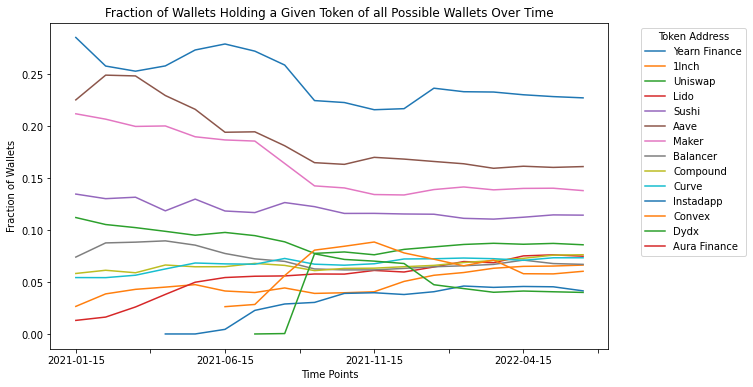

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the DataFrame using line plot
ax = df_token_fractional_ownership.T.plot(kind='line', figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Time Points')
plt.ylabel('Fraction of Wallets')
plt.title('Fraction of Wallets Holding a Given Token of all Possible Wallets Over Time')

# Show legend
plt.legend(title='Token Address', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


## Experiment 1: Between Tokens by Tokenholders 

In [ ]:
from scipy.stats import hypergeom 
# hypergeom.cdf(x,M,n,N,loc=0)	

import pandas as pd
def main(address1, address2, pop_size):

    # get unique addresses 
    token1_uniqa = ddf[ddf.token_address == address1].address.unique()
    token2_uniqa = ddf[ddf.token_address == address2].address.unique()

    # calcluate intersection 
    token1_token2_uniqa_intersection = np.intersect1d(token1_uniqa,token2_uniqa, assume_unique=True)

    # calcualte number 
    len_token1 = len(token1_uniqa)
    len_token2 = len(token2_uniqa)
    len_intersection = len(token1_token2_uniqa_intersection)

    # calculate hyptoge

    # Define the parameters of the distribution
    M = pop_size  # population size
    n = len_token1  # number of draws
    K = len_token2  # number of successes in population
    x = len_intersection    # number of successes in draws

    # Compute the cumulative probability of obtaining at most x successes
    pvalue = 1 - hypergeom.cdf(x, M, n, K)
    
    # print(f'token_address {address1} has {len_token1} Unique Addresses | token_address {address2} has {len_token2} Unique Addresses | Intersection: {len_intersection}, p value: {pvalue}')

    return pvalue

In [35]:
# # Demo
# # test tokens 
# test_token1 = '0x111111111117dc0aa78b770fa6a738034120c302'
# test_token2 = '0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e'

# # calc pop_size
# pop_size = len(ddf.address.unique()) 

# # main
# main(test_token1,test_token2, pop_size)

token_address 0x111111111117dc0aa78b770fa6a738034120c302 has 89015 Unique Addresses | token_address 0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e has 48927 Unique Addresses | Intersection: 5071, p value: 4.2270811950739784e-07


4.2270811950739784e-07

In [8]:
pop_size = len(ddf.address.unique()) 
p_dict = {}

for combination in itertools.combinations(df_addresses.address, 2): 

    pvalue = main(combination[0],combination[1], pop_size)

    p_dict[combination] = pvalue

## Experiment 2: Between Tokens by Token Balance 

In [156]:
covalent_key

'ckey_205246b0f1bb476c8a40542f755'

In [159]:
# step 0: make a lookup table based on snapshot and tokens present in the data set (save API calls) 
# step 1: assign usd value to each row with a given token contract into a new column called "historicial_price" 
# step 2: Adjust value to of each token by relevant number of decimals 
# step 3: Multiple token balance by "historical price"
# step 4: create tokenweight sum 


import requests

def convert_blockheight_to_date(snapshot, covalent_key): 
    
    """Takes block_height and returns date.

    Args:
        snapshot (str): block height

    Returns:
        str: date of format YYYY-MM-DD

    Raises:
        None
    """
    
    url = f"https://api.covalenthq.com/v1/eth-mainnet/block_v2/{snapshot}/?key={covalent_key}"

    response = requests.get(url)
    
    date = response.json()['data']['items'][0]['signed_at']
    
    date_YMD = date.split('T')[0]
    
    return date_YMD


def usd_value_decimals_token(snapshot, contractAddress, covalent_key, chainName = 'eth-mainnet', quoteCurrency = 'USD'): 
    
    """Takes blockheight and contract address of token and
    returns contract_decimals and value in usd.

    Args:
        snapshot (str): block height.
        contractAddress (str): token contract address

    Returns:
        dict with keys and value pairs: 
        'contract_address': contractAddress (str)
        'token_price_usd': price_usd_per_token (int)
        'contract_decimals': decimals (int)

    Raises:
        None
    """
    
    date = convert_blockheight_to_date(snapshot, covalent_key)
    
    
    url = f"https://api.covalenthq.com/v1/pricing/historical_by_addresses_v2/{chainName}/{quoteCurrency}/{contractAddress}/?key={covalent_key}"
    
    params = {
    "from": date, # (YYYY-MM-DD)
    "to": date # (YYYY-MM-DD)
    }

    response = requests.get(url, params=params)
    
    # token price 
    price_usd_per_token = response.json()['data'][0]['prices'][0]['price']
    
    # decimals
    decimals = response.json()['data'][0]['contract_decimals']
    
    return {'contract_address': contractAddress, 'token_price_usd': price_usd_per_token, 'contract_decimals': decimals}
    
    

In [164]:
# convert_blockheight_to_date(snapshot, covalent_key)
usd_value_decimals_token(snapshot,'0x111111111117dc0aa78b770fa6a738034120c302', covalent_key, chainName = 'eth-mainnet', quoteCurrency = 'USD')

{'contract_address': '0x111111111117dc0aa78b770fa6a738034120c302',
 'token_price_usd': 1.3449827,
 'contract_decimals': 18}

In [179]:
# modify df - save most likely 

snapshot = '11659570'

ddf['contract_decimals'] = int
ddf['token_price_usd'] = float

data = []

for contract_address in ddf.token_address.unique(): 
    
    response = usd_value_decimals_token(snapshot, contract_address, covalent_key)
    
    ddf.loc[ddf.token_address == contract_address, 'contract_decimals'] = response['contract_decimals']
    ddf.loc[ddf.token_address == contract_address, 'token_price_usd'] = response['token_price_usd']


ddf['address_value_usd'] = (ddf['value']/(10**ddf['contract_decimals']))*ddf['token_price_usd']
ddf['address_value_usd'] = ddf['address_value_usd'].astype(float)

In [13]:
# Demo
# test tokens 
test_token1 = '0x111111111117dc0aa78b770fa6a738034120c302'
test_token2 = '0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e'

# calc pop_size
pop_size = len(ddf.address.unique()) 

# main
main(test_token1,test_token2, pop_size)

token_address 0x111111111117dc0aa78b770fa6a738034120c302 has 89015 Unique Addresses | token_address 0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e has 48927 Unique Addresses | Intersection: 5071, p value: 4.2270811950739784e-07


4.2270811950739784e-07

### Evaluate p values 



In [14]:
df_pvalues = pd.DataFrame.from_dict(p_dict, orient='index')

df_pvalues.reset_index(inplace=True)

df_pvalues.columns =  ['combination', 'p_value']



In [15]:
from statsmodels.stats.multitest import multipletests as m_tests
# Ref.: https://www.statsmodels.org/devel/generated/statsmodels.stats.multitest.multipletests.html#statsmodels.stats.multitest.multipletests
m_test = m_tests(pvals=df_pvalues.p_value, alpha=0.01, method='bonferroni')


In [16]:
df_pvalues['m_test_result'] = m_test[0]
df_pvalues['m_test_value'] = m_test[1]
df_pvalues.to_csv('pvalues_snapshot_14967365.csv')

## Experiment 3: Between Wallets

In [24]:
ddf1 = ddf[ddf.pct_supply > 0.00005]

In [23]:
ddf1.groupby('token_address').pct_supply.sum()

token_address
0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e    0.933784
0x111111111117dc0aa78b770fa6a738034120c302    0.975327
0x1a4b46696b2bb4794eb3d4c26f1c55f9170fa4c5    0.994668
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984    0.958888
0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b    0.980964
0x5a98fcbea516cf06857215779fd812ca3bef1b32    0.977033
0x6b3595068778dd592e39a122f4f5a5cf09c90fe2     0.95737
0x6f40d4a6237c257fff2db00fa0510deeecd303eb    0.987988
0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9    0.933692
0x92d6c1e31e14520e676a687f0a93788b716beff5    0.986038
0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2    0.951662
0xba100000625a3754423978a60c9317c58a424e3d    0.979069
0xc00e94cb662c3520282e6f5717214004a7f26888    0.971168
0xc0c293ce456ff0ed870add98a0828dd4d2903dbf    0.996093
0xd533a949740bb3306d119cc777fa900ba034cd52    0.968928
Name: pct_supply, dtype: object

In [119]:
# Define a function to compute the p-values for a batch of wallet addresses
def calculate_pvalues(batch_indicies):
    # Compute the product of the pivot sparse matrix and its transpose for the batch
    batch_sparse = pivot_sparse[batch_indicies[0]:batch_indicies[1],:]
    product_sparse = batch_sparse.dot(pivot_sparse.T)

    # Compute the p-value matrix for the batch
    x = product_sparse.A  #the number of "successes" in your sample (i.e. the number of addresses in group 2 that hold a given token)
    M = product_sparse.sum() # the population size (i.e. the total number of addresses in your dataset)
    n = product_sparse.diagonal() # the number of "successes" in the population (i.e. the number of addresses that hold a given token)
    K = product_sparse.sum(axis=0).A.flatten() # the sample size (i.e. the number of addresses in group 1)

    # Reshape n based on the batch size
    n_shape = (batch_indicies[1] - batch_indicies[0], 1)
    n = n.reshape(n_shape)

    pvalue_matrix = 1 - hypergeom.cdf(x, M, n, K)

    return pvalue_matrix

In [129]:
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
from scipy.sparse import csr_matrix
from multiprocessing import Pool, cpu_count

# Define the batch size and number of workers
batch_size = 1024  # ensure batch size is large enough as otherwise the hypergeom will might be wrongly aprrox.
num_workers = 96 #use 80% of cpus to avoid crashing server

# Group the data by token_address and count the number of addresses holding each token
token_address_counts = ddf.groupby('token_address')['address'].nunique()

# Convert the DataFrame to a sparse matrix
pivot_sparse = csr_matrix(pd.crosstab(ddf['address'], ddf['token_address']).values)


# Define a function to compute the p-values for a batch of wallet addresses
def calculate_pvalues(batch_indicies):
    # Compute the product of the pivot sparse matrix and its transpose for the batch
    batch_sparse = pivot_sparse[batch_indicies[0]:batch_indicies[1],:]
    product_sparse = batch_sparse.dot(pivot_sparse.T)

    # Compute the p-value matrix for the batch
    x = product_sparse.A  #the number of "successes" in your sample (i.e. the number of addresses in group 2 that hold a given token)
    M = product_sparse.sum() # the population size (i.e. the total number of addresses in your dataset)
    n = product_sparse.diagonal() # the number of "successes" in the population (i.e. the number of addresses that hold a given token)
    K = product_sparse.sum(axis=0).A.flatten() # the sample size (i.e. the number of addresses in group 1)

    # Reshape n based on the batch size
    n_shape = (batch_indicies[1] - batch_indicies[0], 1)
    n = n.reshape(n_shape)

    pvalue_matrix = 1 - hypergeom.cdf(x, M, n, K)

    return pvalue_matrix
    
# Split the addresses into batches and process them in parallel
pool = Pool(num_workers)
pvalue_matrices = []

#  batch size, with an adjustment for an even number of rows.
# ind_range = pivot_sparse.shape[0] + batch_size if pivot_sparse.shape[0] % 2 != 0 else pivot_sparse.shape[0]


for i in range(0, pivot_sparse.shape[0], batch_size):
    batch_indices = tuple((i, min(i+batch_size, pivot_sparse.shape[0])))
    calculate_pvalues(batch_indices)
    results = pool.apply_async(calculate_pvalues, args=(batch_indices,))
    pvalue_matrices.append(results.get())
    
pool.close()
pool.join()

# Get the p-value matrices for all batches and concatenate them
pvalue_matrix2 = np.concatenate(pvalue_matrices)



In [122]:
# Apply the Bonferroni correction
alpha = 0.01
num_tests = pvalue_matrix2.size
threshold = alpha / num_tests
bonferroni_matrix2 = np.where(pvalue_matrix2 < threshold, 1, 0)


In [130]:
num_differences = np.count_nonzero(bonferroni_matrix2 != bonferroni_matrix)
print(f"Number of differences: {num_differences}")


Number of differences: 5576512


### Individual link

In [178]:
from scipy.stats import hypergeom 
import pandas as pd


def main_wallets(wallet1, wallet2, pop_size, df):

    # unique token a given address holds
    wallet1_uniqT = df[df.address == wallet1].token_address.unique()
    wallet2_uniqT = df[df.address == wallet2].token_address.unique()

    # calcualte intersection in token holdings (binary)
    wallet1_wallet2_uniqT_intersection = np.intersect1d(wallet1_uniqT,wallet2_uniqT, assume_unique=True)

    # calculate hyptogeometric
    # Define the parameters of the distribution
    M = pop_size  # number of token at a given snapshot    
    n = len(wallet1_uniqT)  # number of draws - number of token wallets1
    K = len(wallet2_uniqT)  # number of successes in population - number of token wallets2
    x = len(wallet1_wallet2_uniqT_intersection) # number of successes in draws - intersection of tokens in wallet1 and wallet2

    # Compute the cumulative probability of obtaining at most x successes
    pvalue = 1 - hypergeom.cdf(x, M, n, K)
    
    # print(f'token_address {address1} has {len_token1} Unique Addresses | token_address {address2} has {len_token2} Unique Addresses | Intersection: {len_intersection}, p value: {pvalue}')

    return wallet1, wallet2, pvalue

In [174]:
# test_pvalues
wallet1 = '0x0000000000000eb4ec62758aae93400b3e5f7f18'
wallet2 = '0x000000000000006f6502b7f2bbac8c30a3f67e9a'
pop_size = len(ddf_test.token_address.unique())

# 
main_wallets(wallet1, wallet2, pop_size, ddf_test)


0.0

In [261]:
from itertools import combinations, islice
from concurrent.futures import ProcessPoolExecutor
import pickle

# Define the function that will process a batch of combinations
def process_batch(batch):
    results = []
    for combination in batch:
        # Call your function here to process the combination
        result = main_wallets(combination[0], combination[1], pop_size, ddf_test)
        results.append(result)
    return results

# Define the size of the batches
batch_size = 10

# Generate all possible combinations
combinations_generator = combinations(ddf_test.address.unique(), 2) # generator expression to save memory

# calculate the number of combinations
num_combinations = math.comb(len(ddf_test.address.unique()), 2)


# Divide the combinations into batches
batches = [list(islice(combinations_generator, batch_size)) for i in range(0, num_combinations, batch_size)]

# Open the output file for writing
with open("bipartite_complex_systems_wallet_network_projection/p_values.pkl", "wb") as outfile:
    
    # Create a ProcessPoolExecutor with the desired number of processes
    with ProcessPoolExecutor(max_workers=16) as executor:
        results = []
        # Process each batch in parallel
        for batch in batches:
            batch_result = executor.submit(process_batch, batch)
            results.append(batch_result)

        # Wait for all results to be returned
        for future in results:
            batch_result = future.result()
            # Write the batch result to the pickle file
            pickle.dump(batch_result, outfile)

In [356]:
num_combinations

19701

In [265]:
# Read the results back from the pickle file
pk_result = []

with open("bipartite_complex_systems_wallet_network_projection/p_values.pkl", "rb") as infile:
    while True:
        try:
            result = pickle.load(infile)
            # Do something with the result
            pk_result.append(result)
        except EOFError:
            break

In [271]:
df_pval = pd.DataFrame(np.concatenate(pk_result), columns=['address_1', 'address_2', 'p_value'])


In [357]:
len(df_pval)

19701

In [280]:
# reconstruct pvalue_matrix1 
rows = list(pd.crosstab(ddf_test['address'], ddf_test['token_address']).index)
columns = list(pd.crosstab(ddf_test['address'], ddf_test['token_address']).columns)

In [124]:
pvalue_matrix2 = np.zeros((pivot_sparse.shape[0], pivot_sparse.shape[0]))

for ind_r, row in enumerate(rows):
        
    for ind_c, col in enumerate(rows):
        
        if row == col: 
            
             p_value = [0.0]
        
        else: 
            p_value = df_pval[(df_pval.address_1 == row) & (df_pval.address_2 == col)].p_value.values
                    
        print(p_value[0])
        pvalue_matrix2[ind_r, ind_c] = float(p_value[0])


In [345]:
type(pvalue_matrix1[0,0])

numpy.float64

In [317]:
for i in df_pval.address_1:
    
    print (i) 
    
    break 

0x000be27f560fef0253cac4da8411611184356549


In [306]:
df_pval#[df_pval.address_1.isin([col]) ==True]
df_pval.address_1[0]

'0xd533a949740bb3306d119cc777fa900ba034cd52'

In [258]:
cb = combinations(ddf_test.address.unique(), 2)
num_combinations

19701

In [ ]:
for i in batches: 
    
    for k in enumerate(i): 
        
        print(k)

In [209]:
# Generate all possible combinations of addresses in ddf_test
combinations_generator = combinations(ddf_test.address.unique(), 2)

# Loop over the combinations and extract the p-values
pvalues = []
for pair in combinations_generator:
    # Get the row and column indices for the pair in pivot_sparse
    row_idx = ddf_test.address == pair[0]
    col_idx = ddf_test.address == pair[1]
    
    # Extract the p-value from pvalue_matrix2
    pvalue = pvalue_matrix1[row_idx.indices[0], col_idx.indices[0]]
    
    # Append the p-value to the list
    pvalues.append(pvalue)


AttributeError: 'Series' object has no attribute 'indices'

In [1]:
import math
math.comb(ddf[ddf.pct_supply > 0.00001].address.nunique(),2) #419501894406



NameError: name 'ddf' is not defined

In [185]:
pd.DataFrame(np.concatenate(result_list), columns = ['address1', 'address2', 'p-value'])

,address1,address2,p-value
0,0x000be27f560fef0253cac4da8411611184356549,0x02c2e03c5f241794909d953f5b8fa630856f172c,0.06666666666666643
1,0x000be27f560fef0253cac4da8411611184356549,0x0437ac6109e8a366a1f4816edf312a36952db856,0.06666666666666643
2,0x000be27f560fef0253cac4da8411611184356549,0x0626c02a34287b56b8fa5861516f58ca36faef33,0.06666666666666643
3,0x000be27f560fef0253cac4da8411611184356549,0x06601571aa9d3e8f5f7cdd5b993192618964bab5,0.06666666666666643
4,0x000be27f560fef0253cac4da8411611184356549,0x06a77eb094ef4e0ca19729770b6b115b57e188f8,0.06666666666666643
...,...,...,...
19696,0xfea88380baff95e85305419eb97247981b1a8eee,0xff052381092420b7f24cc97fded9c0c17b2cbbb9,0.06666666666666643
19697,0xfea88380baff95e85305419eb97247981b1a8eee,0xffc97d72e13e01096502cb8eb52dee56f74dad7b,0.06666666666666643
19698,0xfeb4acf3df3cdea7399794d0869ef76a6efaff52,0xff052381092420b7f24cc97fded9c0c17b2cbbb9,0.06666666666666643
19699,0xfeb4acf3df3cdea7399794d0869ef76a6efaff52,0xffc97d72e13e01096502cb8eb52dee56f74dad7b,0.06666666666666643


In [180]:
from scipy.stats import hypergeom 
import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

# population is the size of the possible token that can be held in the sample 
pop_size = len(ddf_test.token_address.unique())

# Define the batch size for computing the p-values
batch_size = 1000

# Compute a set of all unique pairs of wallet addresses that have already been processed
processed_pairs = set()

# Define a function to compute the p-values for a batch of wallet address pairs
def compute_pvalues(wallet_pairs, pop_size):
    pvalues_batch = []
    for pair in wallet_pairs:
        if pair in processed_pairs:
            # Skip pairs that have already been processed
            continue
        else:
            # Compute the p-value for the current pair of wallet addresses
            pvalue = main_wallets(pair[0], pair[1], pop_size, ddf_test) ##CHANGE BACK TO NON-TEXT

            # Store the p-value in the batch list
            pvalues_batch.append(pvalue)

    # Return a tuple of the wallet address pairs and their corresponding p-values
    return wallet_pairs, pvalues_batch

# Compute the p-values for all pairs of wallet addresses in batches
pvalues_dict = {}
num_pairs = len(ddf_test.address.unique()) * (len(ddf_test.address.unique()) - 1) // 2

with concurrent.futures.ProcessPoolExecutor() as executor, \
        tqdm(total=num_pairs, desc='Overall Progress') as pbar_total:

    futures = []
    with tqdm(total=num_pairs, desc='Job Submission') as pbar_submit:
        for i in range(0, len(ddf_test.address.unique()), batch_size):
            # Get a batch of wallet addresses
            wallets_batch = ddf_test.address.unique()[i:i+batch_size]

            # Submit a job to compute the p-values for pairs of wallet addresses that have not yet been processed
            for j in range(i+batch_size, len(ddf_test.address.unique()), batch_size):
                # Get another batch of wallet addresses
                wallets_batch2 = ddf_test.address.unique()[j:j+batch_size]

                # Compute the set of pairs of wallet addresses to process
                wallet_pairs = [(w1, w2) for w1 in wallets_batch for w2 in wallets_batch2]

                # Submit a job to compute the p-values for the current batch of wallet address pairs
                futures.append(executor.submit(compute_pvalues, wallet_pairs, pop_size))

                # Update the job submission progress bar
                pbar_submit.update(len(wallet_pairs))

    # Collect the results from the completed jobs
    with tqdm(total=len(futures), desc='Processing Jobs') as pbar_process:
        for future in concurrent.futures.as_completed(futures):
            # Get the results from the completed job
            wallet_pairs, pvalues_batch = future.result()

            # Store the p-values in a dictionary keyed by the wallet address pairs
            for i, pair in enumerate(wallet_pairs):
                pvalues_dict[pair] = pvalues_batch[i]

            # Update the set of processed pairs
            processed_pairs.update(wallet_pairs)

            # Update the processing progress bar
            pbar_process.update(1)

            # Update the overall progress bar
            pbar_total.update(len(wallet_pairs))
        

# Compute the Bonferroni-corrected significance threshold
alpha = 0.01
n_pairs = len(pvalues_dict)
threshold = alpha / n_pairs

# Compute the list of significant pairs of wallet addresses
significant_pairs = [pair for pair, pvalue in pvalues_dict.items() if pvalue < threshold]


Job Submission:   0%|          | 0/19701 [00:00<?, ?it/s]

Processing Jobs: 0it [00:00, ?it/s]
Overall Progress:   0%|          | 0/19701 [00:00<?, ?it/s]


ZeroDivisionError: float division by zero

### Visualise

/tmp/ipykernel_509454/3814355643.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pvalues_validated.combination = df_pvalues_validated.combination.apply(lambda x: literal_eval(x))


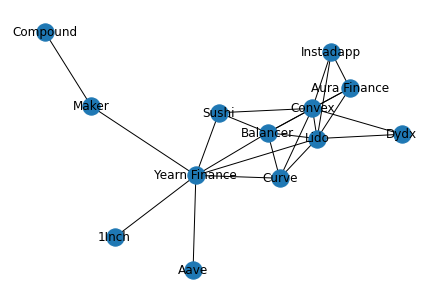

<Figure size 432x288 with 0 Axes>

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from ast import literal_eval


df_pvalues = pd.read_csv('pvalues_snapshot_14967365.csv', index_col=[0])

df_pvalues_validated = df_pvalues[df_pvalues.m_test_result == True]
df_pvalues_validated.combination = df_pvalues_validated.combination.apply(lambda x: literal_eval(x))  
# Create an empty graph
G = nx.Graph()

# Add the edges to the graph
G.add_edges_from(df_pvalues_validated.combination)

# create labels 
df_a_fil = df_addresses[df_addresses.address.isin(list(G.nodes()))]
labels = df_a_fil[['address', 'name']].set_index('address').to_dict()['name']

# visualise netwotk 
nx.draw(G, labels=labels)

#show
plt.show()
plt.savefig('vNetwork_14967365.png')


## Building Adjacency matrices and analysing them 

An adjacency matrix is a mathematical representation of a graph that uses a matrix to describe the connections between nodes in the graph. In this matrix, each row and column represents a node, and the value at the intersection of the row and column represents the weight or strength of the connection between those nodes. If there is no connection between two nodes, the value is typically set to zero.

Combining adjacency matrices from different snapshots allows us to analyze the changes and dynamics of the graph over time. By comparing the adjacency matrices from different time points, we can see how the connections between nodes change, which nodes become more or less connected, and how the overall structure of the graph evolves. This information can help us better understand the behavior of the system represented by the graph and can provide insights into important network phenomena, such as the spread of information or the emergence of communities.

In [18]:
# load snapshots
df_snapshots = pd.read_csv('assets/snapshot_selection.csv')

# load tokens - act as ground truth 
df_tokens = pd.read_csv('assets/df_final_token_selection_20221209.csv')


In [238]:
## one grouping 
adj_matrix_list = [] 
edge_list_doc = {}

for block_height in df_snapshots[df_snapshots['Block Height']>= 11659570]['Block Height']: 


    # load pvalues 
    df_pvalues = pd.read_csv(join(path,f'output/output_f-none/pvalues_{block_height}_none.csv'), index_col=[0])
    df_pvalues.combination = df_pvalues.combination.apply(lambda x: literal_eval(x))

    # create empty adj_matrx
    adj_matrix = np.zeros((len(df_tokens), len(df_tokens)))

    edge_list_projection = [] 
    # populate adj_matrix
    for index, row in df_pvalues.iterrows(): 

        # get address combination
        token1, token2 = row.combination

        # define index & col     
        t1_ind = df_tokens.loc[df_tokens.address == token1].index[0]
        t2_ind = df_tokens.loc[df_tokens.address == token2].index[0]


        # check if validated 
        if row.m_test_result == True:

            # populate adj matrix
            adj_matrix[t1_ind, t2_ind] = 1
            adj_matrix[t2_ind, t1_ind] = 1

            # projected links 
            edge_list_projection.append(tuple((token1, token2)))

        else: 
            # populate adj matrix
            adj_matrix[t1_ind, t2_ind] = 0   


    # append adj_matrix 
    adj_matrix_list.append(adj_matrix)
    edge_list_doc[block_height] = edge_list_projection

In [241]:
ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh14967365_v2.csv"), index_col=[0])


def manipulation(df_token_balenace): 
    
    ddf = df_token_balenace.rename(columns={'address_x': 'address'})
    ddf = ddf.rename(columns={'address_x': 'address'})

    # we only consider non-zero at snapshot 
    ddf = ddf[ddf.value > 0]

    ## keys 
    dict_ts = dict(ddf.groupby('token_address').value.sum())
    dict_ts.keys()

    ## define supply 
    ddf['pct_supply'] = int

    ## define supply
    for t in dict_ts.keys(): 

        ddf.loc[ddf.token_address == t, 'pct_supply'] = ddf[ddf.token_address == t].value / dict_ts[t]
    
    
    #  filter latest tokens 
    df_addresses = pd.read_csv('assets/df_final_token_selection_20221209.csv')
    ddf = ddf[ddf.token_address.isin(df_addresses.address) == True]

    # remove known burner addresses 
    ddf = ddf[ddf.address.isin(known_burner_addresses) == False]
    
    return ddf 

ddf = manipulation(ddf)



In [195]:
## all groupins 

folders = ['output_f-EMOA', 'output_f-IEMOA', 'output_f-none', 'output_f-pcv', 'output_f-other-bridge-vesting-pcv'] #'output_f-IEMOA-EMOA', 'output_f-lp-amm',
filters = ['EMOA', 'IEMOA', 'none', 'pcv', 'other-bridge-vesting-pcv'] #'IEMOA-EMOA', 'lp-amm', 


dict_stack_matrix = {}


for folder, filt in zip(folders, filters): 
    
    adj_matrix_list = [] 
    edge_list_doc = {}

    for block_height in df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height']: 
        
        # load pvalues 
        df_pvalues = pd.read_csv(join(path,f'output/{folder}/pvalues_{block_height}_{filt}.csv'), index_col=[0])
        
        df_pvalues.combination = df_pvalues.combination.apply(lambda x: literal_eval(x))

        # create empty adj_matrx
        adj_matrix = np.zeros((len(df_tokens), len(df_tokens)))

        edge_list_projection = [] 
        # populate adj_matrix
        for index, row in df_pvalues.iterrows(): 

            # get address combination
            token1, token2 = row.combination

            # define index & col     
            t1_ind = df_tokens.loc[df_tokens.address == token1].index[0]
            t2_ind = df_tokens.loc[df_tokens.address == token2].index[0]


            # check if validated 
            if row.m_test_result == True:

                # populate adj matrix
                adj_matrix[t1_ind, t2_ind] = 1
                adj_matrix[t2_ind, t1_ind] = 1

                # projected links 
                edge_list_projection.append(tuple((token1, token2)))

            else: 
                # populate adj matrix
                adj_matrix[t1_ind, t2_ind] = 0   


        # append adj_matrix 
        adj_matrix_list.append(adj_matrix)
        edge_list_doc[block_height] = edge_list_projection
    
    
    stacked_adj_matrix = np.stack(adj_matrix_list, axis=2)
    dict_stack_matrix[folder] = stacked_adj_matrix
    

    

In [114]:
stacked_adj_matrix = np.stack(adj_matrix_list, axis=2)

In [279]:
### sample size 

sample_size_list = []

for filt in filters: 
    
    for block_height in df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height']: 
        
        ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh{block_height}_v2.csv"), index_col=[0])
        
        ddf = manipulation(ddf)
        
        if filt == 'none': 
            
            sample_size_list.append([filt, block_height, len(ddf.address.unique()), len(ddf.token_address.unique())])
            
        elif filt == 'other-bridge-vesting-pcv':
            
            sub_label_list = [    'internal_staking_contracts',    'external_staking_contracts',    'lp_amm',    'lending_borrowing_contract',    'EMOA',    'IEMOA']

            sample_size_list.append([filt, block_height, len(ddf[ddf.label.isin(sub_label_list) == False].address.unique()), len(ddf.token_address.unique())])
            
        else: 
        
            sample_size_list.append([filt, block_height, len(ddf[ddf.label == filt].address.unique()), len(ddf.token_address.unique())])

        
        
df_sample = pd.DataFrame(sample_size_list)        

In [282]:
df_sample['filter'].unique()

array(['EMOA', 'IEMOA', 'none', 'pcv', 'other-bridge-vesting-pcv'],
      dtype=object)

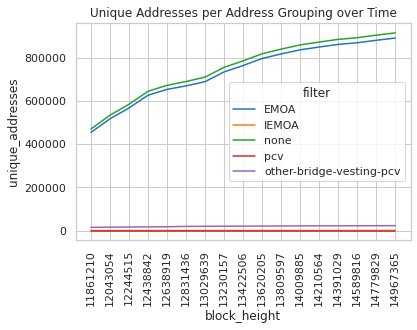

In [290]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sample.columns = ['filter', 'block_height', 'unique_addresses', 'token_addresses']
df_sample.block_height = df_sample.block_height.astype(str)

# Set the style of the plot
sns.set_style("whitegrid")

# Create a line plot for unique_addresses and token_addresses
sns.lineplot(x='block_height', y='unique_addresses', hue='filter', data=df_sample)

# Set the title and axis labels
plt.title('Unique Addresses per Address Grouping over Time')
ax.set_xlabel('Block Height')
ax.set_ylabel('Number of Token Addresses')

# rotate the x-axis labels
plt.xticks(rotation=90)

# save fig 
plt.savefig("outputs/poster_presentation/unique_address_over_time.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/tmp/ipykernel_509454/3522060016.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



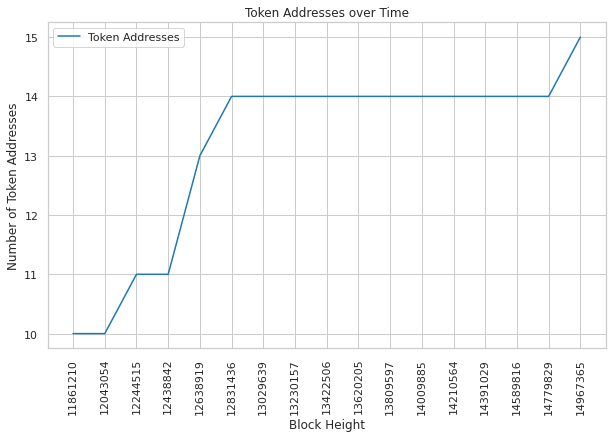

In [287]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create the line plot for token addresses
sns.lineplot(x='block_height', y='token_addresses', data=df_sample[df_sample['filter']=='none'], ax=ax, label='Token Addresses')

# Set the title and axis labels
ax.set_title('Token Addresses over Time')
ax.set_xlabel('Block Height')
ax.set_ylabel('Number of Token Addresses')

# Rotate the x-axis labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# save fig 
plt.savefig("outputs/poster_presentation/tokens_over_time_address_groupings.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [327]:
G = nx.from_numpy_array(dict_stack_matrix['output_f-none'].sum(axis=2))

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


# Define positions for the nodes
pos = nx.spring_layout(G, scale=2, k=20)

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Define a colormap for the edge weights using a seaborn palette
cmap = sns.color_palette("Blues", as_cmap=True)

# create labels 
labels = dict(df_addresses.name)

# Draw the graph with edge colors depending on their weights
nx.draw(G, pos, edge_color=edge_weights, edge_cmap=cmap, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v): G[u][v]['weight'] for u, v in G.edges()})

# Add node labels to the graph
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

# Add a colorbar to the graph
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array(edge_weights)
# cbar = plt.colorbar(sm, ax=plt.gca())

# Add a title to the graph
plt.title('Most-frequent Statistically Validated Network Graph Link over Time')

plt.savefig('outputs/poster_presentation/Most_frequent_Validated_Network_Graph_over_Time.png', dpi=300, bbox_inches='tight')

plt.show()


/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


NameError: name 'G' is not defined

In [394]:
## validated link during possible existance 
len(df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height'])

17

In [427]:
# get edge weight sums 

df_connection_frequency = pd.DataFrame([[df_tokens.address.loc[u],df_tokens.address.loc[v], G[u][v]['weight']] for u, v in G.edges()], columns=['node1', 'node2', 'total_occurances'])


token_timestep_dict = {} # address, no of times it occur in all timestpes

# check in how many network projection the link could have theoretically existed
for ind, block_height in enumerate(df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height']): 
        
        ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh{block_height}_v2.csv"), index_col=[0])
        
        ddf = manipulation(ddf)
        
        for token in ddf.token_address.unique(): 
            
            if token not in list(token_timestep_dict.keys()):
                
                # number of occurances
                no = len(df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height']) - ind
                
                # update token_timestep_dict
                
                token_timestep_dict[token] = no 
                
            else:
                pass
                



In [428]:
df_connection_frequency['possible_occurances'] = int

# devided existance versus occurances 
for ind, row in df_connection_frequency.iterrows(): 
        
    if token_timestep_dict[row.node1] >= token_timestep_dict[row.node2]:
        
        df_connection_frequency.loc[ind, 'possible_occurances'] = token_timestep_dict[row.node2]
    
    else:
    
        df_connection_frequency.loc[ind, 'possible_occurances'] = token_timestep_dict[row.node1]

    
    


In [442]:
df_connection_frequency['pct_frequency'] = df_connection_frequency.total_occurances/df_connection_frequency.possible_occurances

In [443]:
df_connection_frequency.replace(df_tokens[['name','address']].set_index('address').to_dict()['name'], inplace=True)

In [444]:
df_connection_frequency

,node1,node2,total_occurances,possible_occurances,peristance,pct_frequency
0,Uniswap,Instadapp,2.0,15,0.133333,0.133333
1,Aave,Yearn Finance,17.0,17,1.000000,1.000000
2,Aave,Instadapp,2.0,15,0.133333,0.133333
3,Lido,Curve,17.0,17,1.000000,1.000000
4,Lido,1Inch,5.0,17,0.294118,0.294118
5,Lido,Convex,13.0,13,1.000000,1.000000
6,Lido,Dydx,9.0,12,0.750000,0.750000
7,Lido,Balancer,17.0,17,1.000000,1.000000
8,Lido,Sushi,11.0,17,0.647059,0.647059
9,Lido,Yearn Finance,14.0,17,0.823529,0.823529


/tmp/ipykernel_509454/1288682701.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



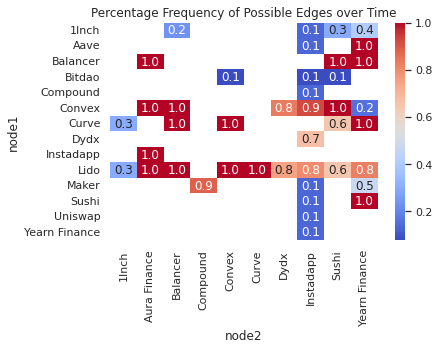

In [446]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Pivot the DataFrame to create a matrix of values
matrix = df_connection_frequency.pivot('node1', 'node2', 'pct_frequency')

# Create the heatmap
sns.heatmap(matrix, cmap='coolwarm', annot=True, fmt='.1f')

# Add a title to the plot
plt.title('Percentage Frequency of Possible Edges over Time')

# save 
plt.savefig('outputs/poster_presentation/pct_frequency_across_Time.png', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


In [324]:
# Define positions for the nodes
pos = nx.spring_layout(G_summed_projections)

# Extract edge weights
edge_weights = [G_summed_projections[u][v]['weight'] for u, v in G_summed_projections.edges()]


# Define a color mapping function based on edge weights
vmin = min(edge_weights)
vmax = max(edge_weights)
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('Reds')
sm = ScalarMappable(norm=norm, cmap=cmap)
colors = [sm.to_rgba(weight) for weight in edge_weights]

# Draw the graph with edge weights
nx.draw(G_summed_projections, pos, width=edge_weights, edge_color='gray', with_labels=True)
nx.draw_networkx_edge_labels(G_summed_projections, pos, edge_labels={(u,v): G_summed_projections[u][v]['weight'] for u, v in G_summed_projections.edges()})

# Adjust the spacing between the nodes
plt.subplots_adjust(wspace=1, hspace=1)

# show
plt.show()

NameError: name 'ScalarMappable' is not defined

In [ ]:
### similaity between user groups 

In [173]:
def jaccard_similarity(matrix1, matrix2):
    set1 = set(np.reshape(matrix1, -1))
    set2 = set(np.reshape(matrix2, -1))
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / union
    return similarity

In [196]:
options = list(dict_stack_matrix.keys())
combinations = list(itertools.combinations(options, 2))

In [197]:
similarity_dict ={}

for a, b in combinations: 
    
    # jaccard similarity of overall matrices 
    matrix1 = dict_stack_matrix[a]
    matrix2 = dict_stack_matrix[b]
    
    # convert each matrix into a set of connections at each time step
    connections1 = [set(zip(*np.where(matrix1[:,:,i] == 1))) for i in range(matrix1.shape[2])]
    connections2 = [set(zip(*np.where(matrix2[:,:,i] == 1))) for i in range(matrix2.shape[2])]
    
    # calculate Jaccard similarity between sets of connections at each time step
    similarities = [len(conn1.intersection(conn2)) / len(conn1.union(conn2)) for conn1, conn2 in zip(connections1, connections2)]

    # calculate average Jaccard similarity across all time steps
    avg_similarity = sum(similarities) / len(similarities)

    print("Average Jaccard similarity between the two 3D matrices: {:.2f}".format(avg_similarity))
    
    # 
    similarity_dict[tuple((a,b))] = avg_similarity
    

Average Jaccard similarity between the two 3D matrices: 0.25
Average Jaccard similarity between the two 3D matrices: 0.86
Average Jaccard similarity between the two 3D matrices: 0.04
Average Jaccard similarity between the two 3D matrices: 0.89
Average Jaccard similarity between the two 3D matrices: 0.26
Average Jaccard similarity between the two 3D matrices: 0.06
Average Jaccard similarity between the two 3D matrices: 0.26
Average Jaccard similarity between the two 3D matrices: 0.08
Average Jaccard similarity between the two 3D matrices: 0.96
Average Jaccard similarity between the two 3D matrices: 0.04


/tmp/ipykernel_509454/3580459640.py:15: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



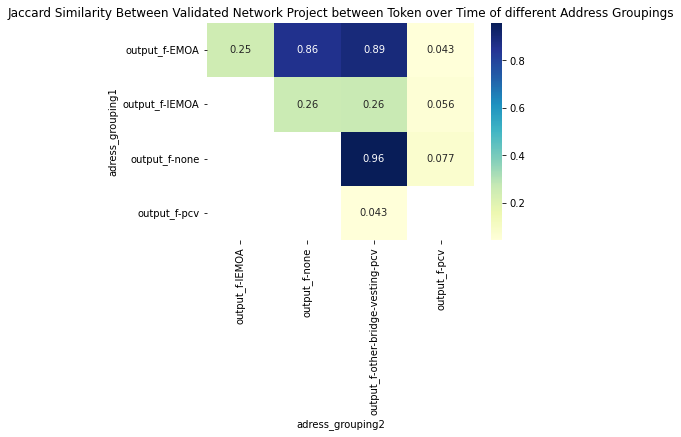

In [199]:
import seaborn as sns 
# Convert the dictionary to a dataframe
df_similarity_dict = pd.DataFrame.from_dict(similarity_dict, orient='index').reset_index()

# Split the index into separate columns
df_similarity_dict[['adress_grouping1', 'adress_grouping2']] = pd.DataFrame(df_similarity_dict['index'].tolist(), index=df_similarity_dict.index)

# Rename the columns
df_similarity_dict = df_similarity_dict.rename(columns={0: 'similarity'})

# Drop the old index column and the index columns we just created
df_similarity_dict = df_similarity_dict.drop(['index'], axis=1)

# Pivot the table
pivot_table = df_similarity_dict.pivot('adress_grouping1', 'adress_grouping2', 'similarity')

# Create the heatmap using seaborn
ax = sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")

# Set the title
ax.set_title("Jaccard Similarity Between Validated Network Project between Token over Time of different Address Groupings")

# Save the image as a PNG file
plt.savefig("outputs/poster_presentation/validated_network_jaccard_over_time_address_groupings.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


### Analysis of stacked_adj_matrix 
- jaccard similarity over time 
- Pair appear vs pair existance - 2d matrix with % values - number of observation/ number of possible occurances - represent as heatmap

In [102]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

In [216]:
snapshot_list = list(df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height'])

list_of_list = []

for matrix_name in dict_stack_matrix.keys():


    for ind in range(dict_stack_matrix[matrix_name].shape[-1] - 1):

        G_1 = nx.from_numpy_array(dict_stack_matrix[matrix_name][:,:,ind])
        G_2 = nx.from_numpy_array(dict_stack_matrix[matrix_name][:,:,ind+1])

        ## jaccard similarity 
        coef = jaccard_similarity(G_1.edges(), G_2.edges())

        ## snapshot 
        snap = snapshot_list[ind+1]

        list_of_list.append([matrix_name, str(snap), coef])

In [221]:
df_jaccard_similarity = pd.DataFrame(list_of_list, columns=['wallet_grouping', 'block_height', 'jaccard_similarity'])

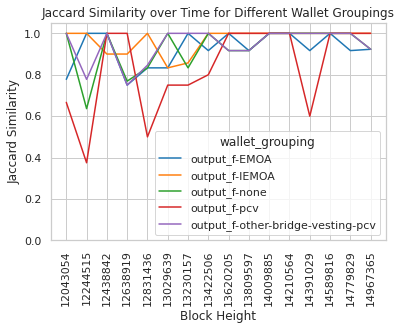

In [269]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and context of the plot
sns.set_style('whitegrid')
sns.set_context('notebook')

# Create the line plot
sns.lineplot(x='block_height', y='jaccard_similarity', hue='wallet_grouping', data=df_jaccard_similarity)

# Set the title and axes labels
plt.title('Jaccard Similarity over Time for Different Wallet Groupings')
plt.xlabel('Block Height')
plt.ylabel('Jaccard Similarity')

# move the legend outside of the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# rotate the x-axis labels
plt.xticks(rotation=90)

# set the y-axis limits
plt.ylim(0, 1.05)

# save 
plt.savefig("outputs/poster_presentation/jaccard_over_time_address_groupings.png", dpi=500, bbox_inches='tight')


# Show the plot
plt.show()

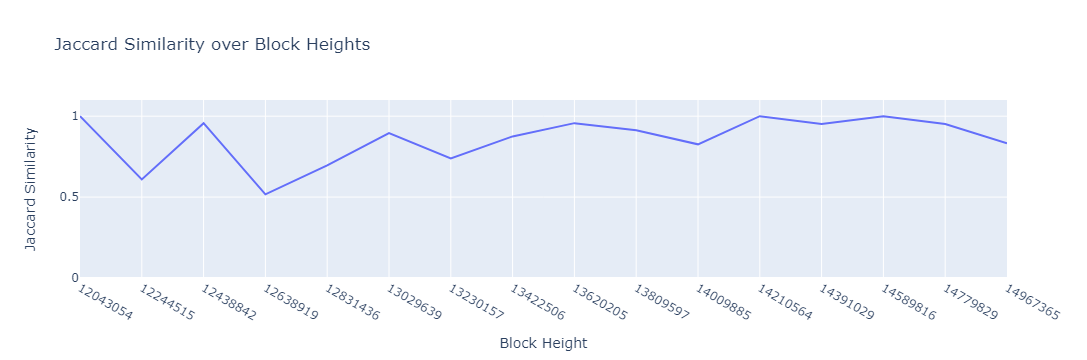

In [164]:
import plotly.express as px

df_jaccard_similarity = pd.DataFrame(list(dict_jaccard_similarity.items()), columns=['block_height','jaccard_similarity'])

# create the plot
fig = px.line(df_jaccard_similarity, x='block_height', y='jaccard_similarity',
              labels={'block_height': 'Block Height', 'jaccard_similarity': 'Jaccard Similarity'},
              title='Jaccard Similarity over Block Heights')

# set the y-axis range to 0-1
fig.update_yaxes(range=[0, 1.1])

# show the plot
fig.show()

In [120]:
snapshots = list(edge_list_doc.keys())

for ind in range(len(snapshots)-1): 
    
    if ind == len(snapshots): 
        
        break 
        
    else: 
        
        G_1 = nx.from_edgelist(edge_list_doc[snapshots[ind]])
        G_2 = nx.from_edgelist(edge_list_doc[snapshots[ind+1]])
    

        # Compute the Jaccard similarity
        nodes1 = set(G_1.edges())
        nodes2 = set(G_2.edges())
        jaccard1 = len(nodes1.intersection(nodes2)) / len(nodes1.union(nodes2))
        
        
        print((snapshots[ind],snapshots[ind+1]), jaccard1)
     



(11861210, 12043054) 0.875
(12043054, 12244515) 0.6086956521739131
(12244515, 12438842) 0.9565217391304348
(12438842, 12638919) 0.41935483870967744
(12638919, 12831436) 0.3448275862068966
(12831436, 13029639) 0.8947368421052632
(13029639, 13230157) 0.7391304347826086
(13230157, 13422506) 0.875
(13422506, 13620205) 0.9565217391304348
(13620205, 13809597) 0.9130434782608695
(13809597, 14009885) 0.75
(14009885, 14210564) 1.0
(14210564, 14391029) 0.9523809523809523
(14391029, 14589816) 1.0
(14589816, 14779829) 0.9523809523809523
(14779829, 14967365) 0.5714285714285714


# Network Metric to Analyse 

- **Clustering statistics** - Number of addresses: “Each data point refers to the totals observed up to a given block, with weekly frequency, and time “flows” from the bottom left to the top right of the panel.” ([Campajola et al., 2022, p. 2](zotero://select/library/items/RYAYFRFR))
    
- **Degree distributions** - “The degree of a node represents the number of counterparts that entity exchanges tokens with, and is typically considered a measure of importance within the network. What is particularly relevant is to consider the distribution of degrees, as its shape is a direct consequence of the way in which the networks form.” ([Campajola et al., 2022, p. 3](zotero://select/library/items/RYAYFRFR)) ([pdf](zotero://open-pdf/library/items/LMUZEWY6?page=3))
    
- **Core-periphery structure** - “This *[edit. core-periphery structure]* is a macroscopic property of the network, that presents a split between a minority of nodes (the “core”) with a strong connectivity between themselves and the remaining nodes of the network (the “periphery”) that are mostly connected to core nodes and have relatively few links to other peripheral nodes.” ([Campajola et al., 2022, p. 4](zotero://select/library/items/RYAYFRFR)) ([pdf](zotero://open-pdf/library/items/LMUZEWY6?page=4))
    
    - “weekly transaction networks time-series and then consider the size of the core group as a fraction of the total size of the network” ([Campajola et al., 2022, p. 4](zotero://select/library/items/RYAYFRFR)) ([pdf](zotero://open-pdf/library/items/LMUZEWY6?page=4))
        
    - Relative size is used to assess centralisation or decentralisation trend
        
- **Mining concentration** - “The Nakamoto index provides us with a measure of the system’s distance from a 51% attack” ([Campajola et al., 2022, p. 5](zotero://select/library/items/RYAYFRFR)) ([pdf](zotero://open-pdf/library/items/LMUZEWY6?page=5))
    
- **Wealth inequality and spatial distribution -** “We define as wealth the balance held by an entity (address or cluster of addresses) at a given point in time, representing the funds that they are entitled to spend according to the blockchain ledger.” ([Campajola et al., 2022, p. 6](zotero://select/library/items/RYAYFRFR))
    
    - Token distribution and Gini Coefficient

### Quantify basic network metrics 

- The number of nodes and edges in the graph. This can give you a sense of the size and complexity of the graph.

In [ ]:
G.number_of_edges()
G.number_of_nodes()

- The degree distribution of the graph. This describes the number of connections (or "degrees") that each node has.

In [ ]:
## degree 
degrees = dict(G.degree())
# Calculate the average degree of the graph
avg_degree = sum(degrees.values()) / len(degrees)
print(avg_degree)


# Calculate the maximum degree of the graph
max_degree = max(degrees.values())
print(max_degree)

# Calculate the minimum degree of the graph
min_degree = min(degrees.values())
print(min_degree)




- The diameter and average shortest path length of the graph. The diameter is the longest shortest path between any two nodes in the graph, and the average shortest path length is the average of all the shortest paths in the graph. These statistics can give you a sense of how "connected" the graph is.

In [ ]:
# diameter
nx.diameter(G)

# average shortest path
nx.average_shortest_path_length(G)


- The density of the graph. This is the ratio of the number of edges in the graph to the maximum number of edges that the graph could have. A dense graph has a high number of edges, while a sparse graph has a low number of edges.

In [ ]:
nx.density(G)

- The degree centrality and betweenness centrality of the nodes in the graph. The degree centrality of a node is a measure of how many connections it has, and the betweenness centrality of a node is a measure of how important it is for connecting other nodes in the graph

In [ ]:
# centrality 
g_degree_centrality = dict(nx.degree_centrality(G))
sum(g_degree_centrality.values())/ len(g_degree_centrality)


# betweeness 
g_betweeness_centrality = dict(nx.betweenness_centrality(G))
sum(g_betweeness_centrality.values())/ len(g_betweeness_centrality)



- clustering coefficient - Algorithms to characterize the number of triangles in a graph.

In [ ]:
g_triangles = dict(nx.triangles(G))
sum(g_triangles.values())/ len(g_triangles)

g_clustering = dict(nx.clustering(G))
sum(g_clustering.values())/ len(g_clustering)



### repeat for other snapshot 

In [ ]:
# imports

import pandas as pd
import numpy as np

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import itertools

from os.path import join
from scipy.stats import hypergeom 
from statsmodels.stats.multitest import multipletests as m_tests
import matplotlib.pyplot as plt
from ast import literal_eval
import networkx as nx


summary_stats = {}


progress = 0 

# snapshot selection 
df_snapshot = pd.read_csv('assets/snapshot_selection.csv')

# address selection 
df_addresses = pd.read_csv('assets/df_final_token_selection_20221209.csv')

# burner addresses 
# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']



#### functions ####

def main(address1, address2, pop_size):

    # get unique addresses 
    token1_uniqa = ddf[ddf.token_address == address1].address.unique()
    token2_uniqa = ddf[ddf.token_address == address2].address.unique()

    # calcluate intersection 
    token1_token2_uniqa_intersection = np.intersect1d(token1_uniqa,token2_uniqa, assume_unique=True)

    # calcualte number 
    len_token1 = len(token1_uniqa)
    len_token2 = len(token2_uniqa)
    len_intersection = len(token1_token2_uniqa_intersection)

    # calculate hyptoge

    # Define the parameters of the distribution
    M = pop_size  # population size
    n = len_token1  # number of draws
    K = len_token2  # number of successes in population
    x = len_intersection    # number of successes in draws

    # Compute the cumulative probability of obtaining at most x successes
    pvalue = 1 - hypergeom.cdf(x, M, n, K)
    
    # print(f'token_address {address1} has {len_token1} Unique Addresses | token_address {address2} has {len_token2} Unique Addresses | Intersection: {len_intersection} | p value: {pvalue}')

    return pvalue

###################


for snapshot in df_snapshot['Block Height']:

    # Info
    items_left = len(df_snapshot) - progress
    progress += 1
    print(
        f"Current Snapshot: {snapshot} || Items processed: {progress} || Items left: { (items_left) }"
    )

    ## formating of data
    # load data
    ddf = dd.read_csv(join(path, f'token_balance_lookup_tables/token_holder_snapshot_balance_{snapshot}.csv'))

    # filter data 
    ddf = ddf[ddf.value > 0]
    ddf = ddf[ddf.token_address.isin(df_addresses.address) == True]

    # remove known burner addresses 
    ddf = ddf[ddf.address.isin(known_burner_addresses) == False]

    # population size
    pop_size = len(ddf.address.unique()) 
    p_dict = {}

    # reduce address list 
    
    present_addresses = list(ddf.token_address.unique().compute())

    if len(present_addresses) == 1:

        print('One address only')
        stats = {'nodes': np.nan, 'possible_nodes': len(present_addresses), 'edges': np.nan, 'avg_degree_path': np.nan, 'min_degree_path': np.nan, 'max_degree_path': np.nan,'diameter': np.nan, 'avg_shortest_path': np.nan, 'density': np.nan, 'degree_centrality_avg': np.nan, 'degree_centrality_min': np.nan, 'degree_centrality_max': np.nan, 'betweeness_centrality_avg': np.nan, 'betweeness_centrality_min': np.nan, 'betweeness_centrality_max': np.nan, 'triangles_avg': np.nan, 'triangles_min': np.nan, 'triangles_max': np.nan}


    else:

        try:
            # iterations 
            for combination in itertools.combinations(present_addresses, 2): 

                pvalue = main(combination[0],combination[1], pop_size)

                p_dict[combination] = pvalue

            ## Evaluate pvalues
            # store pvalues 
            df_pvalues = pd.DataFrame.from_dict(p_dict, orient='index')
            df_pvalues.reset_index(inplace=True)
            df_pvalues.columns =  ['combination', 'p_value']

            # value test 
            m_test = m_tests(pvals=df_pvalues.p_value, alpha=0.01, method='bonferroni')
            df_pvalues['m_test_result'] = m_test[0]
            df_pvalues['m_test_value'] = m_test[1]
            df_pvalues.to_csv(join(path, f'output/pvalues_{snapshot}.csv'))


            ## Build graph
            # filter df  
            df_pvalues_validated = df_pvalues[df_pvalues.m_test_result == True]

            # Create an empty graph
            G = nx.Graph()

            # Add the edges to the graph
            G.add_edges_from(df_pvalues_validated.combination)

            # create labels 
            df_a_fil = df_addresses[df_addresses.address.isin(list(G.nodes()))]
            labels = df_a_fil[['address', 'name']].set_index('address').to_dict()['name']

            # visualise netwotk 
            nx.draw(G, labels=labels)

            #show
            plt.savefig(join(path, f'output/pics/pic_vNetwork_{snapshot}.png'))

            # clear img
            plt.clf() 

            ## descriptve statistic
            g_nodes = G.number_of_nodes()
            g_edges = G.number_of_edges()
            ## degree 
            g_degrees = dict(G.degree())
            # Calculate the average degree of the graph

            try: 
                g_avg_degree = sum(g_degrees.values()) / len(g_degrees)
                g_max_degree = max(g_degrees.values())
                g_min_degree = min(g_degrees.values())
            except: 
                g_avg_degree = np.nan
                g_max_degree = np.nan
                g_min_degree = np.nan


            # diameter
            g_diameter = nx.diameter(G)

            # average shortest path
            g_avg_shortest_path = nx.average_shortest_path_length(G)


            g_density = nx.density(G)

            # centrality 
            g_degree_centrality = dict(nx.degree_centrality(G))

            try: 
                g_degree_centrality_avg = sum(g_degree_centrality.values())/ len(g_degree_centrality)
                g_degree_centrality_min = min(g_degree_centrality.values())
                g_degree_centrality_max = max(g_degree_centrality.values())

            except:

                g_degree_centrality_avg = np.nan
                g_degree_centrality_min = np.nan
                g_degree_centrality_max = np.nan

            # betweeness 
            g_betweeness_centrality = dict(nx.betweenness_centrality(G))

            try: 
                g_betweeness_centrality_avg = sum(g_betweeness_centrality.values())/ len(g_betweeness_centrality)
                g_betweeness_centrality_min = min(g_betweeness_centrality.values())
                g_betweeness_centrality_max = max(g_betweeness_centrality.values())

            except:
                g_betweeness_centrality_avg = np.nan
                g_betweeness_centrality_min = np.nan
                g_betweeness_centrality_max = np.nan

            # triangles 
            g_triangles = dict(nx.triangles(G))

            try: 
                g_triangles_avg = sum(g_triangles.values())/ len(g_triangles)
                g_triangles_min = min(g_triangles.values())
                g_triangles_max = max(g_triangles.values())
            except: 
                g_triangles_avg = np.nan
                g_triangles_min = np.nan
                g_triangles_max = np.nan

            # g_clustering = dict(nx.clustering(G))
            # g_clustering_avg = sum(g_clustering.values())/ len(g_clustering)
            # g_clustering_min = min(g_clustering.values())
            # g_clustering_max = max(g_clustering.values())

            stats = {'nodes': g_nodes, 'possible_nodes': len(present_addresses), 'edges': g_edges, 'avg_degree_path': g_avg_degree, 'min_degree_path': g_min_degree, 'max_degree_path': g_max_degree,'diameter': g_diameter, 'avg_shortest_path': g_avg_shortest_path, 'density': g_density, 'degree_centrality_avg': g_degree_centrality_avg, 'degree_centrality_min': g_degree_centrality_min, 'degree_centrality_max': g_degree_centrality_max, 'betweeness_centrality_avg': g_betweeness_centrality_avg, 'betweeness_centrality_min': g_betweeness_centrality_min, 'betweeness_centrality_max': g_betweeness_centrality_max, 'triangles_avg': g_triangles_avg, 'triangles_min': g_triangles_min, 'triangles_max': g_triangles_max}
            # 'clustering_avg': g_clustering_avg, 'clustering_min': g_clustering_min, 'clustering_max': g_clustering_max }

        except: 
            stats = {'nodes': np.nan, 'possible_nodes': len(present_addresses), 'edges': np.nan, 'avg_degree_path': np.nan, 'min_degree_path': np.nan, 'max_degree_path': np.nan,'diameter': np.nan, 'avg_shortest_path': np.nan, 'density': np.nan, 'degree_centrality_avg': np.nan, 'degree_centrality_min': np.nan, 'degree_centrality_max': np.nan, 'betweeness_centrality_avg': np.nan, 'betweeness_centrality_min': np.nan, 'betweeness_centrality_max': np.nan, 'triangles_avg': np.nan, 'triangles_min': np.nan, 'triangles_max': np.nan}
    

summary_stats[snapshot] = stats




In [ ]:


## descriptve statistic
g_nodes = G.number_of_nodes()
g_edges = G.number_of_edges()
## degree 
g_degrees = dict(G.degree())
# Calculate the average degree of the graph
g_avg_degree = sum(g_degrees.values()) / len(g_degrees)
g_max_degree = max(g_degrees.values())
g_min_degree = min(g_degrees.values())


# diameter
g_diameter = nx.diameter(G)

# average shortest path
g_avg_shortest_path = nx.average_shortest_path_length(G)


g_density = nx.density(G)

# centrality 
g_degree_centrality = dict(nx.degree_centrality(G))
g_degree_centrality_avg = sum(g_degree_centrality.values())/ len(g_degree_centrality)
g_degree_centrality_min = min(g_degree_centrality.values())
g_degree_centrality_max = max(g_degree_centrality.values())

# betweeness 
g_betweeness_centrality = dict(nx.betweenness_centrality(G))
g_betweeness_centrality_avg = sum(g_betweeness_centrality.values())/ len(g_betweeness_centrality)
g_betweeness_centrality_min = min(g_betweeness_centrality.values())
g_betweeness_centrality_max = max(g_betweeness_centrality.values())

# triangles 
g_triangles = dict(nx.triangles(G))
g_triangles_avg = sum(g_triangles.values())/ len(g_triangles)
g_triangles_min = min(g_triangles.values())
g_triangles_max = max(g_triangles.values())

g_clustering = dict(nx.clustering(G))
g_clustering_avg = sum(g_clustering.values())/ len(g_clustering)
g_clustering_min = min(g_clustering.values())
g_clustering_max = max(g_clustering.values())

stats = {'nodes': g_nodes, 'edges': g_edges, 
'avg_degree_path': g_avg_degree, 'min_degree_path': g_min_degree, 'max_degree_path': g_max_degree,
'diameter': g_diameter,
'avg_shortest_path': g_avg_shortest_path, 'density': g_density,
'degree_centrality_avg': g_degree_centrality_avg, 'degree_centrality_min': g_degree_centrality_min, 'degree_centrality_max': g_degree_centrality_max, 
'betweeness_centrality_avg': g_betweeness_centrality_avg, 'betweeness_centrality_min': g_betweeness_centrality_min, 'betweeness_centrality_max': g_betweeness_centrality_max,
'triangles_avg': g_triangles_avg, 'triangles_min': g_triangles_min, 'triangles_max': g_triangles_max,
'clustering_avg': g_clustering_avg, 'clustering_min': g_clustering_min, 'clustering_max': g_clustering_max }

In [ ]:
test= {}

test[123] = stats
test[432] = stats 